In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Reshape

from tensorflow.keras.datasets import mnist

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0], [
            tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 512 * 1)
        ]
    )

In [4]:
print ('TF Version :', tf.__version__)

TF Version : 2.7.0


### Utility Function

In [5]:
def __func_plot(title, dataset, list_of_index=None):
    
    # random index of dataset
    if list_of_index == None:
        list_of_index = np.random.randint(dataset.shape[0], size=4).tolist()
    
    # set figure
    plt.figure(figsize=(16, 3))
    
    for c, i in enumerate(list_of_index):
        
        # subplot
        ax = plt.subplot(1, len(list_of_index), c + 1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # plot
        plt.gray()
        plt.title(title)
        plt.imshow(dataset[i])
    
    # show
    plt.show()

# 1. Setup Dataset

In [6]:
# Download Dataset
(x_train, _), (x_test, _) = mnist.load_data()

In [7]:
# Normalization Dataset -> [0, 1]
x_train = x_train / 255.
x_test = x_test / 255.

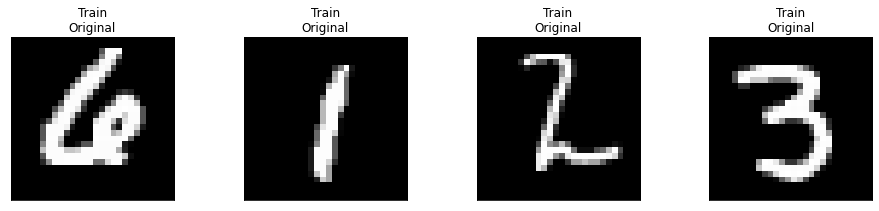

In [8]:
# Dataset Plot
__func_plot('Train\nOriginal', x_train)

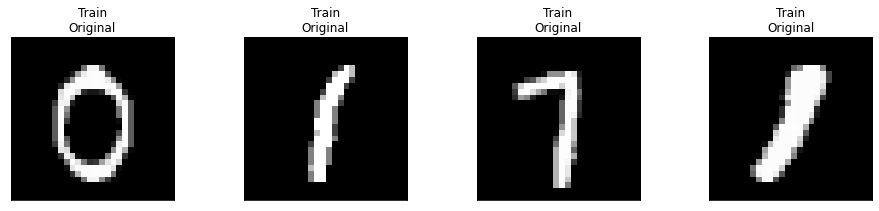

In [9]:
# Dataset Plot
__func_plot('Train\nOriginal', x_test)

# 2. Setup Model

#### - Free Memory

In [10]:
tf.keras.backend.clear_session()

#### - Encoder

In [11]:
# inputs
inputs = Input(shape=(28, 28, 1), name='Inputs')

# layers
x = Conv2D(4, (3, 3), activation='relu', padding='same', strides=2, name='layers-1')(inputs)
x = Conv2D(2, (3, 3), activation='relu', padding='same', strides=2, name='layers-2')(x)

# latents / flatten
latents = Flatten(name='Latents')(x)

# encoder
encoder = Model(inputs, latents, name='Encoder')
encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 layers-1 (Conv2D)           (None, 14, 14, 4)         40        
                                                                 
 layers-2 (Conv2D)           (None, 7, 7, 2)           74        
                                                                 
 Latents (Flatten)           (None, 98)                0         
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________


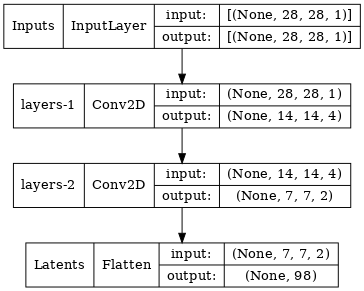

In [12]:
tf.keras.utils.plot_model(encoder, show_shapes=True, dpi=69)

#### - Decoder

In [13]:
# latents
latents = Input(shape=(98), name='Latents')

# latents / reshape
x = Reshape((7, 7, 2), name='Reshape')(latents)

# layers
x = Conv2DTranspose(2, (3, 3), activation='relu', padding='same', strides=2, name='layers-1')(x)
x = Conv2DTranspose(4, (3, 3), activation='relu', padding='same', strides=2, name='layers-2')(x)

# outputs
outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Outputs')(x)

# decoder
decoder = Model(latents, outputs, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Latents (InputLayer)        [(None, 98)]              0         
                                                                 
 Reshape (Reshape)           (None, 7, 7, 2)           0         
                                                                 
 layers-1 (Conv2DTranspose)  (None, 14, 14, 2)         38        
                                                                 
 layers-2 (Conv2DTranspose)  (None, 28, 28, 4)         76        
                                                                 
 Outputs (Conv2D)            (None, 28, 28, 1)         37        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


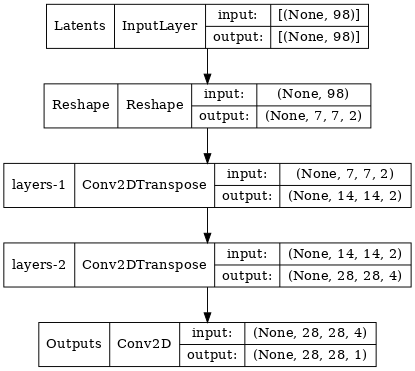

In [14]:
tf.keras.utils.plot_model(decoder, show_shapes=True, dpi=69)

#### - Autoencoder

In [15]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='Autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        (None, 98)                114       
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         151       
                                                                 
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________


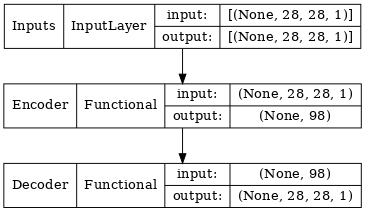

In [16]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True, dpi=69)

# 3. Model Training

In [17]:
# model fit
history = autoencoder.fit(x_train, x_train, epochs=40, validation_split=0.2)

Epoch 1/40
1500/1500 [==============================] - 10s 5ms/step - loss: 0.0459 - val_loss: 0.0161
Epoch 2/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0120 - val_loss: 0.0110
Epoch 3/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 4/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 5/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0096 - val_loss: 0.0096
Epoch 6/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 7/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 8/40
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 9/40
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 10/40
1500/1500 [==============================] - 5s 4ms/step - loss: 0.00

<AxesSubplot:>

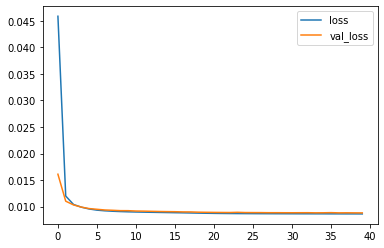

In [18]:
# model performance
pd.DataFrame(autoencoder.history.history).plot()

# 4. Model Evaluation

In [19]:
# model predict
z_test = encoder.predict(x_test)
y_pred = decoder.predict(z_test)

In [20]:
# get list_of_index
list_of_index = np.random.randint(x_test.shape[0], size=5).tolist()

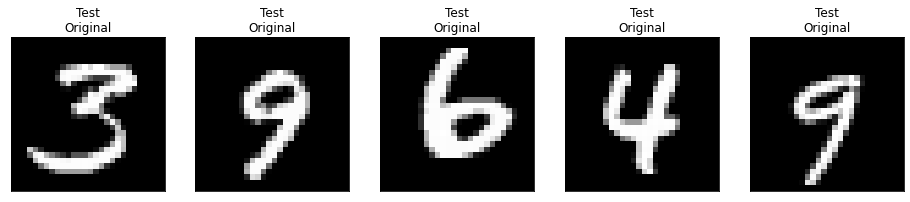

In [21]:
# Dataset Plot
__func_plot('Test\nOriginal', x_test, list_of_index)

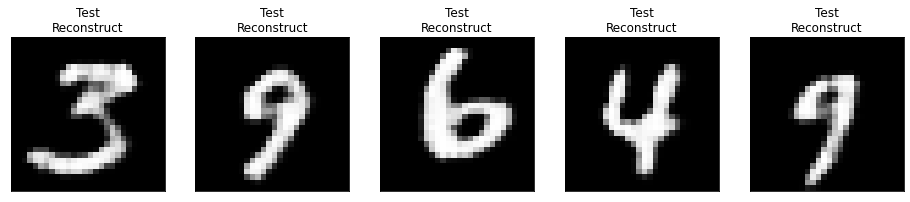

In [22]:
# Dataset Plot
__func_plot('Test\nReconstruct', y_pred, list_of_index)

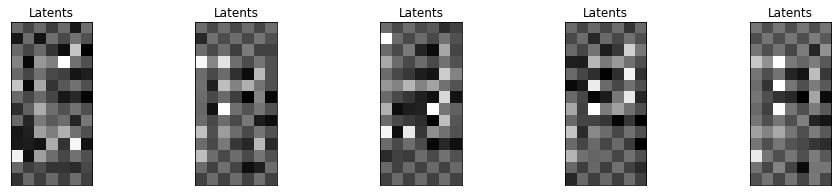

In [23]:
# Dataset Plot
__func_plot('Latents', z_test.reshape(z_test.shape[0], 14, 7), list_of_index)